# Time Series Prediction using LSTM in Python

## Table of Contents

## 1. Introduction

In this notebook, we'll build an LSTM (Long Short-Term Memory) neural network model to perform two-step ahead out-of-sample predictions on a time series dataset. The dataset is in monthly intervals and spans roughly 20 years.

**Objective**:

* Estimate models that perform two-step ahead out-of-sample predictions.
* Evaluate the predictions using RMSE and compare with ARIMA models.

## 2. Importing Libraries

First, we'll import the necessary Python libraries.

In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date and time handling
from datetime import datetime, timedelta

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 3. Loading the Data

We will load the data from a CSV file.

In [4]:
# Load the dataset, we are currently in the exploration folder
df = pd.read_csv('../data_ignore/df_2024-10.csv', parse_dates=['time'], na_values=['NA'])

# Display the first few rows
df.head()

,freq,stk_flow,unit,partner,indic,geo,time,values
0,M,EXP,MIO-EUR-NSA,EXT_EU27_2020,ET-T,EU27_2020,1999-01-01,NaN
1,M,EXP,MIO-EUR-NSA,EXT_EU27_2020,ET-T,EU27_2020,1999-02-01,NaN
2,M,EXP,MIO-EUR-NSA,EXT_EU27_2020,ET-T,EU27_2020,1999-03-01,NaN
3,M,EXP,MIO-EUR-NSA,EXT_EU27_2020,ET-T,EU27_2020,1999-04-01,NaN
4,M,EXP,MIO-EUR-NSA,EXT_EU27_2020,ET-T,EU27_2020,1999-05-01,NaN


Explanation:

* `parse_dates=['time']`: Converts the 'time' column to datetime objects.
* `na_values=['NA']`: Treats 'NA' as NaN (missing values).

## 4. Data Preprocessing

### 4.1 Handling Missing Values

First, let's check for missing values in the 'values' column.

In [5]:
df['values'].isnull().sum()

72

Since there are missing values, we'll drop the rows with NaN in 'values'.

In [6]:
# Drop rows with missing 'values'
df.dropna(subset=['values'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Confirm the number of rows after dropping
print(f"Number of rows after dropping missing values: {len(df)}")

Number of rows after dropping missing values: 8552


### 4.2 Filtering Data for a Specific Country

We'll filter the data for a specific country. Let's use 'EU27_2020' as an example.

In [7]:
# Filter data for 'EU27_2020'
country = 'EU27_2020'
df_country = df[df['geo'] == country].copy()

# Reset index
df_country.reset_index(drop=True, inplace=True)

# Display the first few rows
df_country.head()

,freq,stk_flow,unit,partner,indic,geo,time,values
0,M,EXP,MIO-EUR-NSA,EXT_EU27_2020,ET-T,EU27_2020,2002-01-01,75921.4
1,M,EXP,MIO-EUR-NSA,EXT_EU27_2020,ET-T,EU27_2020,2002-02-01,78349.3
2,M,EXP,MIO-EUR-NSA,EXT_EU27_2020,ET-T,EU27_2020,2002-03-01,86735.4
3,M,EXP,MIO-EUR-NSA,EXT_EU27_2020,ET-T,EU27_2020,2002-04-01,84412.5
4,M,EXP,MIO-EUR-NSA,EXT_EU27_2020,ET-T,EU27_2020,2002-05-01,85247.8


### 4.3 Sorting by Time
Ensure the data is sorted by the 'time' column.

In [8]:
# Sort by 'time'
df_country.sort_values('time', inplace=True)
df_country.reset_index(drop=True, inplace=True)

### 4.4 Scaling the Data
We'll standardize the 'values' column using the `StandardScaler`, similar to the scale2 function in R.

In [9]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the 'values' column
df_country['values_scaled'] = scaler.fit_transform(df_country[['values']])

# Display the scaled values
df_country[['time', 'values', 'values_scaled']].head()

,time,values,values_scaled
0,2002-01-01,75921.4,-1.603867
1,2002-02-01,78349.3,-1.545156
2,2002-03-01,86735.4,-1.342366
3,2002-04-01,84412.5,-1.398538
4,2002-05-01,85247.8,-1.378339


## 5. Exploratory Data Analysis

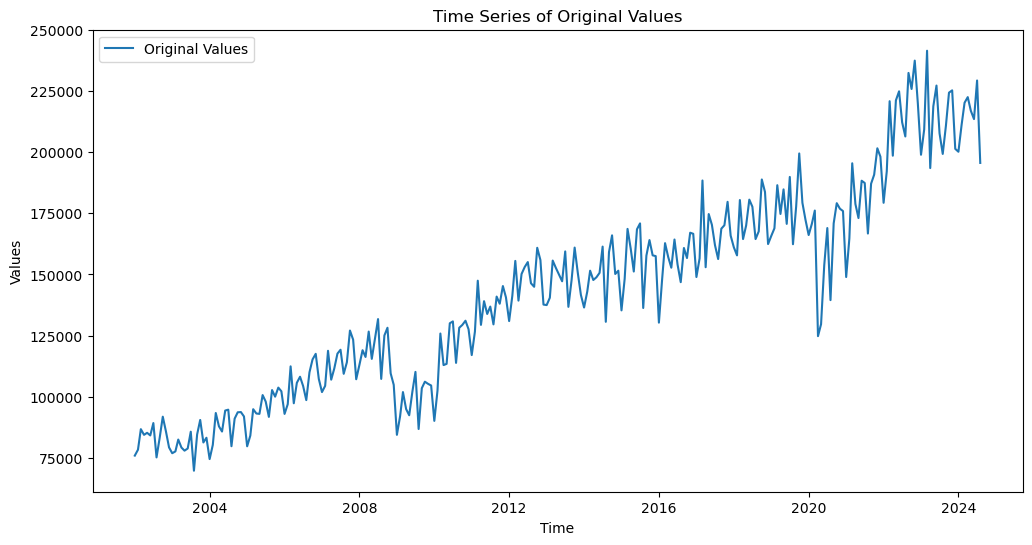

In [10]:
# Plot the original 'values'
plt.figure(figsize=(12,6))
plt.plot(df_country['time'], df_country['values'], label='Original Values')
plt.title('Time Series of Original Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

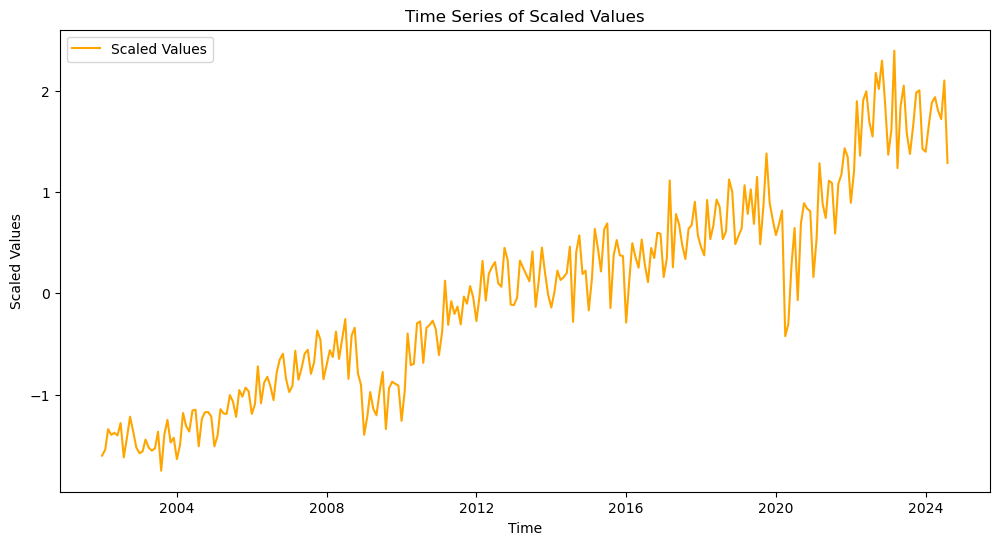

In [12]:
# Plot the scaled 'values'
plt.figure(figsize=(12,6))
plt.plot(df_country['time'], df_country['values_scaled'], label='Scaled Values', color='orange')
plt.title('Time Series of Scaled Values')
plt.xlabel('Time')
plt.ylabel('Scaled Values')
plt.legend()
plt.show()


## 6. Prepare Data for LSTM

### 6.1 Defining Sequence Creation Function
We'll create a function to generate sequences for LSTM input.

In [11]:
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out])
    return np.array(X), np.array(y)

### 6.2 Creating Sequences
Set the number of input steps (n_steps_in) and output steps (n_steps_out).

In [13]:
n_steps_in = 12   # Number of past time steps
n_steps_out = 2   # Number of future time steps to predict

# Extract the 'values_scaled' as a numpy array
data_values = df_country['values_scaled'].values

# Create sequences
X, y = create_sequences(data_values, n_steps_in, n_steps_out)

# Reshape X to be [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Display the shapes
print(f"Input shape: {X.shape}")
print(f"Output shape: {y.shape}")

Input shape: (259, 12, 1)
Output shape: (259, 2)


## 7. Building and Training the LSTM Model

### 7.1 Building the Model
We'll build a simple LSTM model.

In [14]:
# Define the model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, 1)))
model.add(Dense(n_steps_out))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-11-18 12:15:27.299702: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-18 12:15:27.299981: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 10,502
Trainable params: 10,502
Non-trainable params: 0
_________________________________________________________________


### 7.2 Training the Model
We'll train the model using the data.

In [15]:
# Train the model
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50


2024-11-18 12:15:38.833074: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-11-18 12:15:39.191383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 3s 258ms/step - loss: 0.6535 - val_loss: 2.1091
Epoch 2/50


2024-11-18 12:15:42.187957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 149ms/step - loss: 0.5299 - val_loss: 1.3735
Epoch 3/50
8/8 [==============================] - 1s 152ms/step - loss: 0.3898 - val_loss: 0.4539
Epoch 4/50
8/8 [==============================] - 1s 149ms/step - loss: 0.2322 - val_loss: 1.3446
Epoch 5/50
8/8 [==============================] - 1s 150ms/step - loss: 0.1064 - val_loss: 7.0168
Epoch 6/50
8/8 [==============================] - 1s 148ms/step - loss: 0.0917 - val_loss: 0.8055
Epoch 7/50
8/8 [==============================] - 1s 150ms/step - loss: 0.0897 - val_loss: 0.7012
Epoch 8/50
8/8 [==============================] - 1s 149ms/step - loss: 0.0821 - val_loss: 1.2940
Epoch 9/50
8/8 [==============================] - 1s 149ms/step - loss: 0.0802 - val_loss: 2.0824
Epoch 10/50
8/8 [==============================] - 1s 149ms/step - loss: 0.0803 - val_loss: 1.6120
Epoch 11/50
8/8 [==============================] - 1s 149ms/step - loss: 0.0794 - val_loss: 1.5362
Epoch 12/50
8/8 [============

**Explanation**:

* `epochs`: Number of times the model will see the entire dataset.
* `batch_size`: Number of samples per gradient update.
* `validation_split`: Fraction of the data to be used as validation data.

## 8. Making Predictions

### 8.1 Preparing Input for Prediction
We'll use the last `n_steps_in` values to predict the next `n_steps_out` values.

In [16]:
# Get the last 'n_steps_in' data points
x_input = data_values[-n_steps_in:]
x_input = x_input.reshape((1, n_steps_in, 1))

# Make predictions
yhat = model.predict(x_input, verbose=0)


2024-11-18 12:18:00.758176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### 8.2 Inverse Transforming the Predictions
Since we scaled the data, we'll need to inverse transform the predictions to get them back to the original scale.

In [17]:
# Inverse transform the predictions
yhat_transformed = scaler.inverse_transform(yhat)

# Display the predictions
print("Predicted values (original scale):", yhat_transformed.flatten())


Predicted values (original scale): [258135.3  269116.28]


## 9. Evaluating the Model

### 9.1 Comparing with Actual Values
If we have actual future values, we can compare them with our predictions. For demonstration purposes, we'll assume we have the actual values.

In [18]:
# Assuming we have actual future values
# Let's extract them from the dataset (if available)
# Be cautious with indexing to avoid IndexError
try:
    actual_future_values = df_country['values'].values[-n_steps_out:]
except IndexError:
    actual_future_values = np.array([np.nan]*n_steps_out)

print("Actual future values:", actual_future_values)


Actual future values: [229259.3 195564.8]


### 9.2 Calculating RMSE
We'll calculate the Root Mean Square Error (RMSE) between the predicted and actual values.

In [19]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_future_values, yhat_transformed.flatten()))
print(f"RMSE: {rmse}")

RMSE: 55873.265474617256


## 10. Visualizing the Results

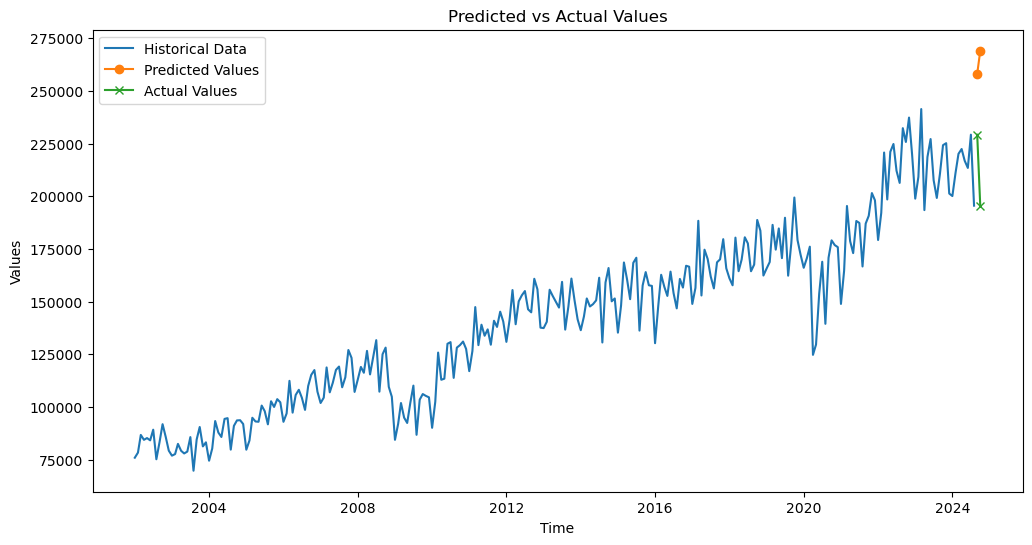

In [20]:
# Prepare data for plotting
prediction_dates = pd.date_range(start=df_country['time'].iloc[-1] + timedelta(days=1), periods=n_steps_out, freq='MS')

# Create a DataFrame for predictions
df_predictions = pd.DataFrame({
    'time': prediction_dates,
    'predicted_values': yhat_transformed.flatten(),
    'actual_values': actual_future_values
})

# Plotting
plt.figure(figsize=(12,6))
plt.plot(df_country['time'], df_country['values'], label='Historical Data')
plt.plot(df_predictions['time'], df_predictions['predicted_values'], label='Predicted Values', marker='o')
plt.plot(df_predictions['time'], df_predictions['actual_values'], label='Actual Values', marker='x')
plt.title('Predicted vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


## 11. Conclusion

In this notebook, we:

* Loaded and preprocessed the time series data.
* Created sequences suitable for LSTM input.
* Built and trained an LSTM model for time series prediction.
* Made two-step ahead predictions.
* Evaluated the model using RMSE.
* Visualized the predictions alongside the actual values.

Next Steps:

* Data Availability: Ensure that you have actual future values to compare with the predictions.
* Hyperparameter Tuning: Experiment with different numbers of LSTM units, epochs, and batch sizes.
* Model Complexity: Consider adding more layers or using techniques like dropout to prevent overfitting.
* Cross-Validation: Use time-series cross-validation methods to better assess model performance.
* Comparison with ARIMA: Compare the LSTM model's performance with your existing ARIMA models.